In [234]:
import keras
import sklearn
import numpy as np
from random import shuffle, sample
from tensorflow import set_random_seed #idée de Malo
from os import listdir
from math import sqrt
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

In [235]:
set_random_seed(1000) #doit avoir la même seed que np.random.seed()
PATH_DATA = "/media/anthony/POULOP/deepdrug3d_voxel_data/"

In [247]:
def metriques(predictions, y, k):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for i in range(predictions.shape[0]):        
        if max(predictions[i]) == predictions[i,k] and y[i,k] == 1.0:
            tp += 1
        elif max(predictions[i]) == predictions[i,k] and y[i,k] != 1.0:
            fp += 1
        elif max(predictions[i]) != predictions[i,k] and y[i,k] != 1.0:
            tn += 1
        elif max(predictions[i]) != predictions[i,k] and y[i,k] == 1.0:
            fn += 1
    return tp*100/len(predictions), fp*100/len(predictions), tn*100/len(predictions), fn*100/len(predictions), (tp+tn)*100/(tp+tn+fp+fn), tp*100/(tp+fp), tn*100/(tn+fp), tp*100/(tp+fn), fp*100/(fp+tn), ((tn*tp)-(fp*fn))/sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))

def roc(predictions, y, i, path):
    preds = predictions[:,i]
    fpr, tpr, threshold = metrics.roc_curve(y[:,i], preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Roc curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Sensibility')
    plt.xlabel('1-Specificity')
    plt.xlabel
    plt.savefig(path)
    plt.show()

def list_generator(file):
    with open(file, "r") as filin:
        liste = ["{}.npy".format(line[:-1]) for line in filin]
    return liste

def x_loader(path, nucleotid, heme, control, steroid, k_train, k_test):
    all_pocket = listdir(path)
    xtrain_id = sample(nucleotid, k_train) + sample(heme, k_train) + sample(control, k_train)
    xtest_id = sample(nucleotid, k_test) + sample(heme, k_test) + sample(control, k_test) + sample(steroid, k_test)
    shuffle(xtrain_id)
    shuffle(xtest_id)
    xtrain = np.empty((len(xtrain_id), 14, 32, 32, 32))
    xtest = np.empty((len(xtest_id), 14, 32, 32, 32))
    for i in range(len(xtrain_id)):
        xtrain[i,:,:,:,:] = np.load("{}{}".format(path,xtrain_id[i]))
        if xtrain[i,:,:,:,:].shape == (1,14,32,32,32):
            np.squeeze(xtrain[i,:,:,:,:])
    for i in range(len(xtest_id)):
        xtest[i,:,:,:,:] = np.load("{}{}".format(path,xtest_id[i]))
        if xtest[i,:,:,:,:].shape == (1,14,32,32,32):
            np.squeeze(xtest[i,:,:,:,:])
        
    ytrain = y_loader(xtrain_id, nucleotid, heme, control, steroid)
    ytest = y_loader(xtest_id, nucleotid, heme, control, steroid)
    return xtrain, xtest, ytrain, ytest

def y_loader(x_list, nucleotid, heme, control, steroid):
    y = np.zeros((len(x_list),3))
    for i in range(len(x_list)):
        if x_list[i] in nucleotid:
            y[i,0] = 1
        elif x_list[i] in heme:
            y[i,1] = 1
        elif x_list[i] in control:
            y[i,2] = 1
    return y

In [239]:
nucleotid = list_generator("nucleotide.list.txt")
heme = list_generator("heme.list.txt")
control = list_generator("control.list.txt")
steroid = list_generator("steroid.list.txt")
print(len(nucleotid))
print(len(heme))
print(len(control))
print(len(steroid))
print(len(nucleotid)+len(heme)+len(control)+len(steroid))
print(len(listdir(PATH_DATA)))

1553
596
1946
69
4164
4164


In [240]:
xtrain, xtest, ytrain, ytest = x_loader(PATH_DATA, nucleotid, heme, control, steroid, 125, 65)
print(xtrain.shape)
print(type(xtrain))
print(True in np.isnan(xtrain))
print(xtest.shape)
print(type(xtest))
print(True in np.isnan(xtest))
print(ytrain.shape)
print(ytest.shape)

(375, 14, 32, 32, 32)
<class 'numpy.ndarray'>
False
(260, 14, 32, 32, 32)
<class 'numpy.ndarray'>
False
(375, 3)
(260, 3)


In [241]:
def jaqua_model(optim_perso):
    input_layer = keras.Input(shape=(14, 32, 32, 32))
    conv_1 = keras.layers.Conv3D(filters = 32, kernel_size = 5, activation = "relu",
                                 data_format = "channels_first", padding = "same")(input_layer)
    conv_2 = keras.layers.Conv3D(filters = 32, kernel_size = 3, activation = "relu",
                                 data_format="channels_first", padding="same")(conv_1)
    dropout_1 = keras.layers.Dropout(rate=0.4)(conv_2)
    max_pooling_1 = keras.layers.MaxPooling3D(pool_size=(2,2,2), strides=None,padding="same",
                                              data_format="channels_first")(dropout_1)
    dropout_2 = keras.layers.Dropout(rate=0.4)(max_pooling_1)
    flatten_1 = keras.layers.Flatten()(dropout_2)
    dense_1 = keras.layers.Dense(units=100, activation="relu")(flatten_1)
    dropout_3 = keras.layers.Dropout(rate=0.4)(dense_1)
    output_layer = keras.layers.Dense(units=3, activation="softmax")(dropout_3)
    notdeepdrug_model = keras.Model(inputs=input_layer,outputs=output_layer)
    notdeepdrug_model.compile(optimizer= optim_perso, loss="categorical_crossentropy",metrics=["accuracy"])
    return notdeepdrug_model

In [242]:
np.random.seed(1000)
optim_perso = keras.optimizers.Adam(learning_rate = 0.00001)
my_model = jaqua_model(optim_perso)
best_model_path = "../results/my_model_28_10_1"+".h5"
best_model = keras.callbacks.ModelCheckpoint(filepath=best_model_path,mode = "min", monitor = "val_loss", verbose = 2, save_best_only=True)
my_model.fit(xtrain,ytrain,batch_size=20,epochs=50,validation_split=0.10,shuffle=True, callbacks = [best_model])
test_evaluation = my_model.evaluate(xtest, ytest, batch_size = 20)
train_evaluation = my_model.evaluate(xtrain, ytrain, batch_size = 20)
print("Test evaluation: {}".format(test_evaluation))
print("Train evaluation: {}".format(train_evaluation))
test_predictions = my_model.predict(xtest, batch_size = 20)
train_predictions = my_model.predict(xtrain, batch_size = 20)

Train on 337 samples, validate on 38 samples
Epoch 1/50
337/337 [==============================] - 146s 434ms/step - loss: 1.4277 - accuracy: 0.3798 - val_loss: 1.1492 - val_accuracy: 0.3684

Epoch 00001: val_loss improved from inf to 1.14924, saving model to ../results/my_model_28_10_1.h5
Epoch 2/50
337/337 [==============================] - 144s 427ms/step - loss: 1.2200 - accuracy: 0.3769 - val_loss: 1.1057 - val_accuracy: 0.2895

Epoch 00002: val_loss improved from 1.14924 to 1.10567, saving model to ../results/my_model_28_10_1.h5
Epoch 3/50
337/337 [==============================] - 147s 435ms/step - loss: 1.1135 - accuracy: 0.3680 - val_loss: 1.0848 - val_accuracy: 0.5263

Epoch 00003: val_loss improved from 1.10567 to 1.08481, saving model to ../results/my_model_28_10_1.h5
Epoch 4/50
337/337 [==============================] - 147s 438ms/step - loss: 1.0934 - accuracy: 0.3828 - val_loss: 1.0880 - val_accuracy: 0.3421

Epoch 00004: val_loss did not improve from 1.08481
Epoch 5/50


In [48]:
fav_model = keras.models.load_model("../results/my_model.h5")
fav_test_evaluation = fav_model.evaluate(xtest, ytest, batch_size = 20)
fav_train_evaluation = fav_model.evaluate(xtrain, ytrain, batch_size = 20)
print(fav_test_evaluation)
print(fav_train_evaluation)
fav_predictions = fav_model.predict(xtest, batch_size = 20)

100/100 [==============================] - 12s 124ms/step
[0.8130654573440552, 0.5600000023841858]


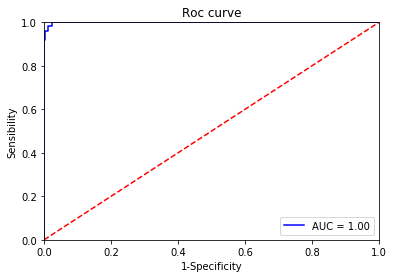

In [243]:
#nucléotides train
roc(train_predictions, ytrain, 0)

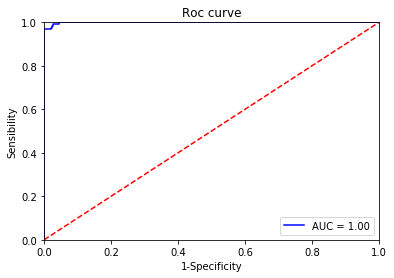

In [244]:
#hème train
roc(train_predictions, ytrain, 1)

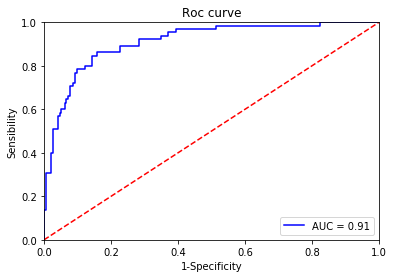

In [248]:
#nucléotide test
roc(test_predictions, ytest, 0, "../results/roc_nt_test")

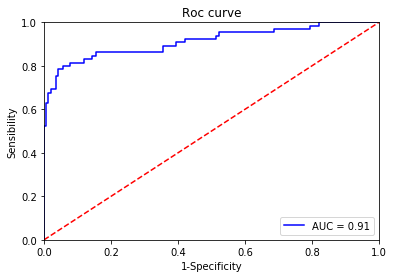

In [249]:
#hèmes test
roc(test_predictions, ytest, 1, "../results/roc_hm_test")

Train heme:

In [250]:
tp, fp, tn, fn, acc, ppv, tnr, tpr, fpr, mcc = metriques(train_predictions, ytrain, 1)
print("TP:{:.2f}%".format(tp))
print("FP:{:.2f}%".format(fp))
print("TN:{:.2f}".format(tn))
print("FN:{:.2f}".format(fn))
print("ACC = {:.2f}%".format(acc))
print("PPV = {:.2f}%".format(ppv))
print("TNR = {:.2f}%".format(tnr))
print("TPR = {:.2f}%".format(tpr))
print("FPR = {:.2f}%".format(fpr))
print("MCC = {:.2f}".format(mcc))

TP:32.27%
FP:1.07%
TN:65.60
FN:1.07
ACC = 97.87%
PPV = 96.80%
TNR = 98.40%
TPR = 96.80%
FPR = 1.60%
MCC = 0.95


Train nucleotides:

In [251]:
tp, fp, tn, fn, acc, ppv, tnr, tpr, fpr, mcc = metriques(train_predictions, ytrain, 0)
print("TP:{:.2f}%".format(tp))
print("FP:{:.2f}%".format(fp))
print("TN:{:.2f}".format(tn))
print("FN:{:.2f}".format(fn))
print("ACC = {:.2f}%".format(acc))
print("PPV = {:.2f}%".format(ppv))
print("TNR = {:.2f}%".format(tnr))
print("TPR = {:.2f}%".format(tpr))
print("FPR = {:.2f}%".format(fpr))
print("MCC = {:.2f}".format(mcc))

TP:32.80%
FP:1.33%
TN:65.33
FN:0.53
ACC = 98.13%
PPV = 96.09%
TNR = 98.00%
TPR = 98.40%
FPR = 2.00%
MCC = 0.96


Test heme:

In [252]:
tp, fp, tn, fn, acc, ppv, tnr, tpr, fpr, mcc = metriques(test_predictions, ytest, 1)
print("TP:{:.2f}%".format(tp))
print("FP:{:.2f}%".format(fp))
print("TN:{:.2f}".format(tn))
print("FN:{:.2f}".format(fn))
print("ACC = {:.2f}%".format(acc))
print("PPV = {:.2f}%".format(ppv))
print("TNR = {:.2f}%".format(tnr))
print("TPR = {:.2f}%".format(tpr))
print("FPR = {:.2f}%".format(fpr))
print("MCC = {:.2f}".format(mcc))

TP:20.38%
FP:10.38%
TN:64.62
FN:4.62
ACC = 85.00%
PPV = 66.25%
TNR = 86.15%
TPR = 81.54%
FPR = 13.85%
MCC = 0.64


Test nucléotides:

In [253]:
tp, fp, tn, fn, acc, ppv, tnr, tpr, fpr, mcc = metriques(test_predictions, ytest, 0)
print("TP:{:.2f}%".format(tp))
print("FP:{:.2f}%".format(fp))
print("TN:{:.2f}".format(tn))
print("FN:{:.2f}".format(fn))
print("ACC = {:.2f}%".format(acc))
print("PPV = {:.2f}%".format(ppv))
print("TNR = {:.2f}%".format(tnr))
print("TPR = {:.2f}%".format(tpr))
print("FPR = {:.2f}%".format(fpr))
print("MCC = {:.2f}".format(mcc))

TP:19.62%
FP:10.38%
TN:64.62
FN:5.38
ACC = 84.23%
PPV = 65.38%
TNR = 86.15%
TPR = 78.46%
FPR = 13.85%
MCC = 0.61


In [256]:
sensi = []
speci = []
for s in np.arange(0.0,1.0,0.025):
    tp = 0
    fn = 0
    for i in range(len(test_predictions)):
        if test_predictions[i,1] >= s:
            if ytest[i,1] == 1.0 and test_predictions[i,1] == max(test_predictions[i,:]):
                tp += 1
            elif ytest[i,1] != 1.0 and test_predictions[i,1] == max(test_predictions[i,:]):
                fp += 1
        else:
            if ytest[i,1] == 1.0 and test_predictions[i,1] != max(test_predictions[i,:]):
                fn += 1
            elif ytest[i,1] != 1.0 and test_predictions[i,1] != max(test_predictions[i,:]):
                tn += 1
    sensi.append(tp/(tp+fn))
    speci.append(tn/(tn+fp))
speci = np.array(speci)
speci = 1 -speci

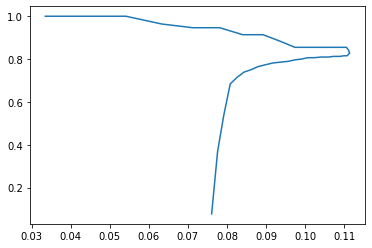

In [257]:
plt.plot(list(speci), sensi)